In [8]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.5 MB/s eta 0:00:00


In [9]:
import Bio.PDB as pdb

# Предсказание ротамеров угла $\chi_1$ в зависимости от окружения

In [1]:
import json
import pandas as pd
import numpy as np

## Запустите следующую клетку. Будет случайно выбрана аминокислота, для которой вы будете проводить исследование

In [2]:
amacid_names = ['ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'HIS', 'ILE', 'LEU',
                'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

print(f"Моя аминокислота - {np.random.choice(amacid_names)}")

Моя аминокислота - TYR


## Загрузите <a href="https://yadi.sk/d/FeLl5KYfjbhHgA?w=1">отсюда</a> соответствующий файл. Далее мы будем работать с ним.

# Часть 1. Анализ значений угла $\chi_1$

## Задание 1.1. Откроем загруженный файл. Посмотрим на колонки:

In [3]:
dpath = "TYR_data.csv"

In [ ]:
dpath = "/Users/andreyignatov/Downloads/SER_data.csv"

In [4]:
df = pd.read_csv(dpath)

In [5]:
df.head()

,Unnamed: 0,pbd_indx,phi,psi,tau,alpha,ind_from_start,ind_from_end,sec_structure,is_tail,...,gamma14,alpha15,beta15,gamma15,alpha16,beta16,gamma16,alpha17,beta17,gamma17
0,0,2BO5,-148.001357,-67.992231,117.157701,-110.703325,11.0,108.0,-,0.0,...,114.580795,36.661160,67.461259,54.652780,14.056945,43.857109,100.998151,19.703593,63.315198,73.225830
1,1,2BO5,-55.714933,-49.908315,90.977755,37.753339,17.0,102.0,H,0.0,...,69.076968,107.687638,168.415868,85.773413,16.502680,92.882349,76.732688,26.697398,58.605741,80.229164
2,2,2BO5,-78.342760,-18.608555,87.632632,83.964880,22.0,97.0,H,0.0,...,118.832041,31.302429,121.968191,72.152814,111.938707,42.869942,115.972377,89.464734,120.572756,88.181731
3,3,2BO5,-85.870711,-30.408628,95.016856,57.634714,58.0,61.0,T,0.0,...,46.561656,33.672983,92.764160,97.069248,37.070288,24.167924,96.798978,39.278673,71.786531,51.187381
4,4,2BW2,-114.553991,-32.869655,94.356042,72.594777,5.0,134.0,E,0.0,...,58.612176,36.047283,14.467107,83.900206,21.524376,60.654675,109.154373,22.350609,61.600486,70.386124


In [12]:
df["pbd_indx"].nunique(), df.shape

(1784, (11310, 301))

In [ ]:
list(df.columns)

Эта таблица содержит информацию о сэмплах одной аминокислоты. Для каждого сэмпла известны:
- Значения всех двугранных углов $\chi$;
- Значения $\phi, \psi, \alpha$ (двугранный угол, построенный по 4 последовательным атомам $C_\alpha$);
- Данные о 17 ближайших пространственных соседях:
    - $\phi, \psi$;
    - Названия аминокислот;
    - Расстояние до целевой аминокислоты по $C_\alpha$;
    - Химические / физикохимические характеристики соседа: группы и точные значения некоторых характеристик;
    - Дополнительные геометрические характеристики (относительно целевой аминокислоты).

## Задание 1.2. Постройте гистограмму значений $\chi_1$ из этой таблицы. Какие ротамеры выделяются на этой гистограмме?

In [14]:
import matplotlib.pyplot as plt

In [15]:
df = df[~np.isnan(df["chi_1"])]

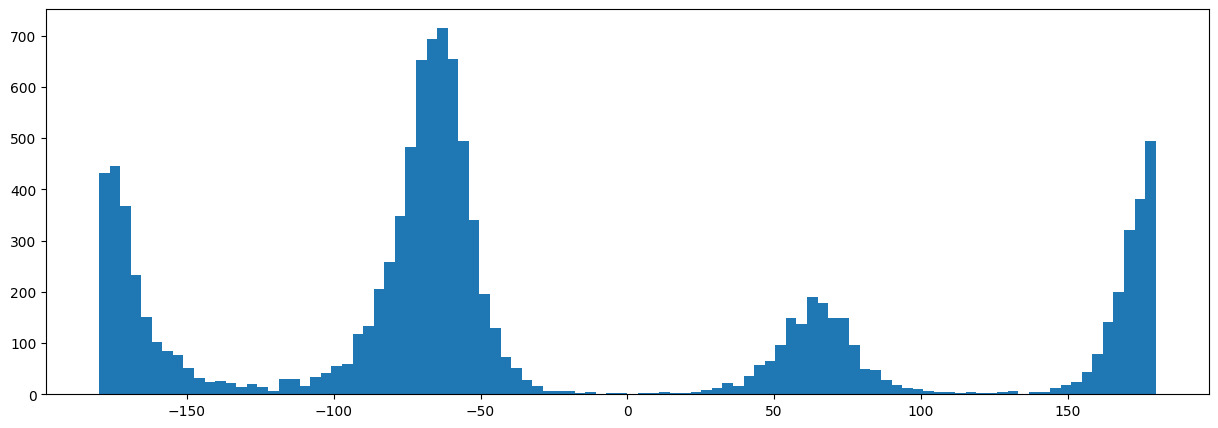

In [16]:
plt.figure(figsize=(15,5))

plt.hist(df["chi_1"], bins=100)

plt.show()

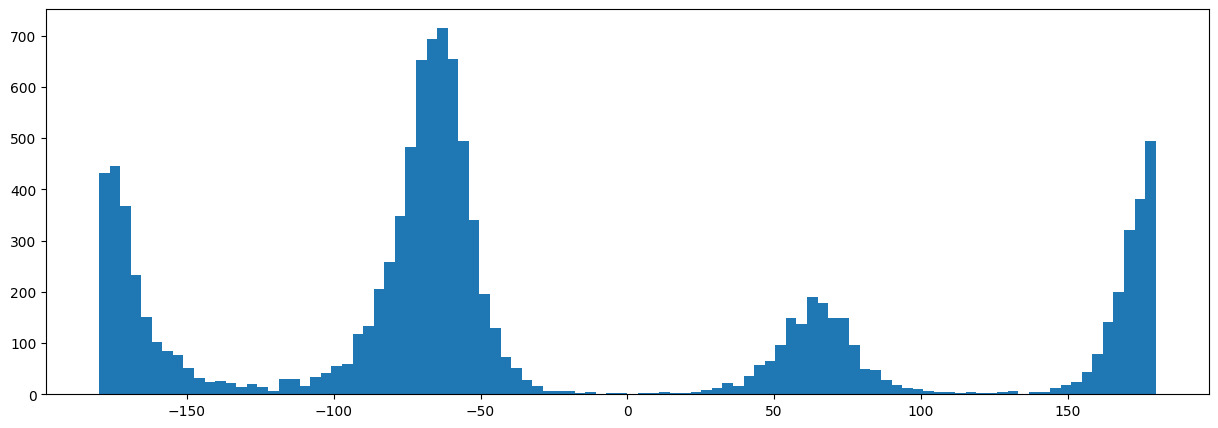

In [18]:
plt.figure(figsize=(15,5))

hs, xs, *_ = plt.hist(df["chi_1"], bins=100)

plt.show()

calculate value

In [19]:
len(hs), len(xs)

(100, 101)

In [20]:
xs = (xs[1:] + xs[:-1]) / 2

In [24]:
rotamer_inds = [i for i in range(3, len(hs))
                if np.all(hs[i - 3:i]<hs[i]) and np.all(hs[i+1:i +4]<hs[i])]
print(rotamer_inds)

[32, 67, 82, 86, 99]


In [25]:
xs[rotamer_inds]

array([-62.99320421,  62.99981593, 116.99682457, 131.39602687,
       178.19343435])

Занесите обнаруженные ротамеры в список rotamers:

In [26]:
rotamers = [-60, 60, 180]

## Задание 1.3. Давайте разберемся, как можно дискретизировать значения (разделить их на классы). Реализуйте функцию get_class(value, rotamers), которая возвращает индекс ротамера, к которому относится значение value.

**Комментарий**: стоит вычислять расстояние от value до каждого значения из rotamers. Но не забудьте, что с точки зрения окружности $-\pi$ и $\pi$ - одно и то же!

In [30]:
def get_class(value, rotamers):
    diffs = np.abs(np.array(rotamers) - value)
    diffs = np.minimum(diffs, 360 - diffs)
    return np.argmin(diffs)

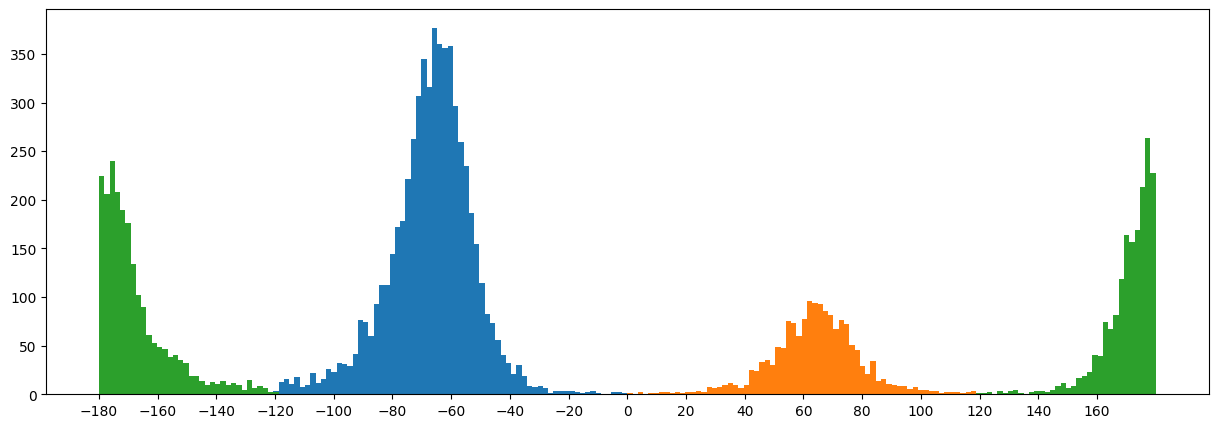

In [31]:
plt.figure(figsize=(15,5))
classes = [get_class(val, rotamers) for val in df["chi_1"]]

for i in np.unique(classes):
    plt.hist(df["chi_1"].values[classes == i], bins=200, range=(-180, 180))

plt.xticks(np.arange(-180, 180, 20))
plt.show()

## Задание 1.4. Теперь мы умеем делить значения $\chi_1$ на классы, т.е. можем понять, к какому ротамеру относится то или иное значение.
Реализуем первую часть подхода Dunbrack. Шаги:
- Разделить карту Рамачандрана на блоки $20 x 20$. Для каждого блока нужно найти те сэмплы из выборки, которые входят в него.
- Для всех найденных сэмплов нужно получить индексы классов; после этого выбрать класс, встречающийся чаще всего, и сохранить его в соответствующую ячейку матрицы **most_common_rotamers**.
    - Если получилось меньше 10 значений для некоторого блока, нужно получить наиболее частый класс для всей выборки.

In [32]:
all_rots = [get_class(val, rotamers) for val in df["chi_1"]]
all_un_rots, all_un_cnts = np.unique(all_rots, return_counts=True)

most_common = all_un_rots[np.argmax(all_un_cnts)]

In [33]:
most_common #must be -60

0

In [ ]:
most_common_rotamers = np.full((18, 18), np.nan)
for phi_ind in range(18):
    phi_st = -180 + 20 * phi_ind
    phi_end = -180 + 20 * (phi_ind + 1)
    for psi_ind in range(18):
        psi_st = -180 + 20 * psi_ind
        psi_end = -180 + 20 * (psi_ind + 1)

        # your code here

Отобразите получившуюся матрицу с помощью plt.imshow:

In [ ]:
plt.imshow(most_common_rotamers)

plt.colorbar()
plt.show()

Какие выводы можно сделать на основании изображения выше? Можно ли сказать, что какой-то ротамер характерен для определенной вторичной структуры?

# $\rightarrow$ Ваши идеи 🙂

## Задание 1.5. А насколько вообще состоятелен подход к поиску пересечений, основанный на энергии van der Waals?

Давайте возьмем достаточно длинный белок $1Z87$, откроем его и изучим:

In [ ]:
import Bio.PDB as pdb

In [ ]:
path = pdb.PDBList().retrieve_pdb_file("1z87",
                                       file_format="pdb")
struct = pdb.PDBParser().get_structure("s", path)

Получите 0-ую цепочку этого белка, найдите в ней индексы всех цистеинов (CYS):

In [ ]:
chain = struct[0].child_list[0]
residues = chain.child_list
cys_inds = # TODO

Выберите первый найденный цистеин. Будем менять для него угол $\chi_1$ и смотреть, как будет меняться энергия ван дер Ваальса при взаимодействии с другими атомами.

$U_{LJ} = 4 \cdot \epsilon \cdot [(\frac{r_{min}}{r})^{12} - 2 \cdot (\frac{r_{min}}{r})^6]$

In [ ]:
lj_coeffs = pd.read_csv("lennard-jones_12-6.csv", delimiter="\t")
lj_coeffs.head()

In [ ]:
def van_der_Waals(d, d_m, eps):
    return  4 * eps * (((d_m / d) ** 12) - 2 * ((d_m / d) ** 6))

Изменяя двугранный угол в пределах $[-\pi, \pi)$:
- Вычислите новые координаты атома SG у цистеина. Для этого можно воспользоваться функциями из файла geometry.py (из первого ДЗ).
- После получения координат, их можно присвоить с помощью метода:

    residue["CG"].set_coord(new_cg1_coord)
- После этого вычислите суммарную энергию ван дер Ваальса взаимодействия со всеми другими атомами белка.

In [ ]:
from geometry import *

Для удобства сделаем словарь из таблицы с коэффициентами потенциала типа Леннарда-Джонса:

In [ ]:
lj_coeffs = {row[0]: {"d_min": float(row[1].replace(",", ".")),
                      "eps": float(row[2].replace(",", "."))} for row in lj_coeffs.values}
lj_coeffs

In [ ]:
def calc_vdw_w_residue(ref_residue, residue):
    ref_atoms = [at
                 for at in ref_residue.child_list
                 if at not in ["C", "N", "CA", "CB", "O"] and at.element[0] != "H"]
    atoms = [at
             for at in residue.child_list
             if at.element[0] != "H"]

    ds, d_ms, epses = [], [], []
    for at1 in ref_atoms:
        for at2 in atoms:
            pair = "{}-{}".format(at1.element, at2.element)
            ds += [at1 - at2]
            d_ms += [lj_coeffs[pair]["d_min"]]
            epses += [lj_coeffs[pair]["eps"]]

    ds =    np.array(ds)
    d_ms =  np.array(d_ms)
    epses = np.array(epses)

    return van_der_Waals(ds, d_ms, epses).sum()


In [ ]:
calc_vdw_w_residue(chain[2], chain[3])

In [ ]:
chi1_vals = np.arange(-np.pi, np.pi, np.pi/10)

cys_residue = residues[cys_inds[0]]

chi1_true = pdb.calc_dihedral(cys_residue["N"].get_vector(),
                              cys_residue["CA"].get_vector(),
                              cys_residue["CB"].get_vector(),
                              cys_residue["SG"].get_vector(),
                             )
planar = pdb.calc_angle(cys_residue["CA"].get_vector(),
                      cys_residue["CB"].get_vector(),
                      cys_residue["SG"].get_vector())
bond = cys_residue["SG"] - cys_residue["CB"]
prev_atoms = np.array([cys_residue["N"].coord,
                       cys_residue["CA"].coord,
                       cys_residue["CB"].coord,
                      ])

vdw_vals = []

for chi1 in chi1_vals:
    new_coord = place_next_dihedral_atom(prev_atoms, chi1, planar, bond)
    cys_residue["SG"].set_coord(new_coord)

    # your code here

Постройте график для получившихся значений энергии. Какой вывод можно сделать из него?

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(chi1_vals, vdw_vals)

plt.show()

In [ ]:
# your ideas here

# Часть 2. Предсказание ротамеров $\chi_1$

В этой части Вам предстоит применить методы Машинного Обучения (деревья решений) к задаче предсказания ротамеров Вашей аминокислоты.

## Задание 2.1. Вернемся к датасету из части 1. Добавьте колонку chi_class, которая получается преобразованием значений из колонки chi_1 к классам.

In [ ]:
# your code here

## Задание 2.2. Теперь давайте дискретизируем значения $\phi, \psi, \alpha$. Каждому значению из $[-\pi, \pi]$ нужно поставить в соответствие номер блока длиной 20 градусов, в который он попадает.

**Комментарий**: обратите внимание, значения могут быть отрицательными. А номер блока нет 🤔

In [ ]:
# your code here

## Задание 2.3. В датасете есть текстовые признаки! Так как они категориальные, их значения можно поменять на натуральные числа. Пронумеруйте все уникальные значения таких признаков и измените текстовые значения на соответствующие номера.

In [ ]:
# your code here

## Задание 2.4. Обучим нашу модель!

Импортируйте библиотеку lightgbm. Если она не установлена, установить ее можно с помощью консольной команды pip:

In [ ]:
# Ваш pip может иметь другую версию / называться по-другому: например, pip3 для python3
! pip3.8 install lightgbm
import lightgbm as lgb

Разделите выборку на обучающую и тестовую в соотношении 0.7/0.3. В X должны быть все признаки, кроме Unnamed, pdb_id и всех столбцов со значениями углов $\chi$. y - столбец дискретизированных значений $\chi_1$.

In [ ]:
# your code here

Обучите модель, проверьте качество обучения на тестовой выборке (по метрике accuracy). Получилось ли хорошая модель?

In [ ]:
clf = lgb.LGBMClassifier(num_leaves=88,
                         min_child_samples=1358,
                         max_depth=16,
                         n_estimators=2170,
                         reg_lambda=702.599,
                         reg_alpha=28.532,
                         learning_rate=0.26461,
                         random_state=42
                        )

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print("Test accuracy score:", accuracy)